# Sparkify - Predicting Churn With Spark
### Giulio Cesare Mastrocinque Santo

#### "*Customer churn is when an existing customer, user, player, subscriber or any kind of return client stops doing business or ends the relationship with a company.*

#### *This could, for example, mean cancellation of a subscription, ending of a membership, closure of an account of some sort, not renewing a service agreement or contract and even a customer deciding to buy his or her groceries in another store.* [1]"

#### In this project I will be developing a full Data Science project in order to predict cutomer churn for a fictitious company called Sparkify. I will be developing all my analysis using Spark through the IBM Watson Studio.

## Table of Content:
* [<font size="4" class="anchor">Imports</font>](#imports)
* [<font size="4" class="anchor">Extract and Clean Data</font>](#extract-clean)
* [<font size="4" class="anchor">Explanatory Data Analysis</font>](#eda)
* [<font size="4" class="anchor">Data Transformation and Feature Engineering</font>](#data-transf)
* [<font size="4" class="anchor">ETL Process</font>](#etl)
* [<font size="4" class="anchor">Predicting Churn With Machine Learning</font>](#ml)

## <a class="anchor" id="imports">Imports</a>

In [22]:
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_style("darkgrid")

In [9]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-641cb602-a856-4241-820f-a99f0f4f9f11',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token',
    'api_key': 'dt7c2kJIRKFY4uY3psyjJg6W7CM7v2OqajQ6Ash3Kvce'
}

configuration_name = 'os_ada30a5c278b4d6bb58a5faa0c7f8edb_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-cz623hxuazrnhw'))
df_data_1.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

## <a class="anchor" id="extract-clean">Extract and Clean Data</a>

#### First, I will verify the data structure!

In [10]:
df_data_1.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



#### Now, I will be searching for Null Values

In [11]:
from pyspark.sql.functions import isnan, when, count, col

df_data_1.filter((df_data_1["userId"] == "") | df_data_1["userId"].isNull() | isnan(df_data_1["userId"])).count()

15700

In [12]:
print("NUMBER OF NULL VALUES PER COLUMN... \n")

df_data_1.select([count(when(df_data_1[c].isNull(), c)).alias(c) for c in df_data_1.columns]).show()

NUMBER OF NULL VALUES PER COLUMN... 

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|  song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|110828|   0|    15700| 15700|            0|   15700|110828|    0|   15700|     0|   0|       15700|        0|110828|     0|  0|    15700|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+



In [13]:
print("NUMBER OF NAN VALUES PER COLUMN... \n")

df_data_1.select([count(when(isnan(df_data_1[c]), c)).alias(c) for c in df_data_1.columns]).show()

NUMBER OF NAN VALUES PER COLUMN... 

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [14]:
print("NUMBER OF BLANK VALUES PER COLUMN... \n")

df_data_1.select([count(when(df_data_1[c] == "", c)).alias(c) for c in df_data_1.columns]).show()

NUMBER OF BLANK VALUES PER COLUMN... 

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0| 15700|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



#### Let's remove NaN values from userID and sessionId columns

In [15]:
df_clean = df_data_1.dropna(how = "any", subset = ["userId", "sessionId"])

#### Now, let's verify the unique values of user Id to verify the identified blank values

In [16]:
df_clean.select("userId").dropDuplicates().sort("userId").show(5)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



#### One can clearly notice the blank id that repeats 15700 times! Let's remove this Id from the analisis

In [17]:
df_clean = df_clean.filter(df_clean.userId != "")

In [18]:
df_clean.select("userId").dropDuplicates().sort("userId").show(5)

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
+------+
only showing top 5 rows



In [19]:
print("NUMBER OF BLANK VALUES PER COLUMN... \n")

df_clean.select([count(when(df_clean[c] == "", c)).alias(c) for c in df_clean.columns]).show()

NUMBER OF BLANK VALUES PER COLUMN... 

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [20]:
print("NUMBER OF NULL VALUES PER COLUMN... \n")

df_clean.select([count(when(df_clean[c].isNull(), c)).alias(c) for c in df_clean.columns]).show()

NUMBER OF NULL VALUES PER COLUMN... 

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 95128|   0|        0|     0|            0|       0| 95128|    0|       0|     0|   0|           0|        0|95128|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



#### Lets adjust the timestamp format for column registration and ts

In [23]:
get_strftime = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

In [24]:
df_clean = df_clean.withColumn("time_stamp", get_strftime(col("ts")))

In [25]:
df_clean = df_clean.withColumn("registration_date", get_strftime(col("registration")))

## <a class="anchor" id="eda">Explanatory Data Analysis</a>

#### In this section, let's try to understand more about our dataset!

#### Let's begin printing the number of unique sessions as well as the number of times stamps

In [26]:
print(f"Number of unique session IDS: {df_clean.select('sessionId').dropDuplicates().count()}")

Number of unique session IDS: 4470


In [27]:
print(f"Number of unique Time Stamps: {df_clean.select('ts').dropDuplicates().count()}")

Number of unique Time Stamps: 499351


#### Ok, now let's see how many user interactions we have in average...

In [28]:
user_avg_iteractions = df_clean.groupby(['userId','gender']).agg(count(col("sessionId")))

In [29]:
user_avg_iteractions = user_avg_iteractions.groupby('gender').mean()

In [30]:
user_avg_iteractions.show()

+------+---------------------+
|gender|avg(count(sessionId))|
+------+---------------------+
|     F|   1138.3484848484848|
|     M|             1210.448|
+------+---------------------+



In [31]:
user_avg_iteractions = user_avg_iteractions.toPandas()

In [32]:
user_avg_iteractions

,gender,avg(count(sessionId))
0,F,1138.348485
1,M,1210.448000


In [33]:
user_avg_iteractions = user_avg_iteractions.rename(columns={'avg(count(sessionId))':'avg_sessionid'})

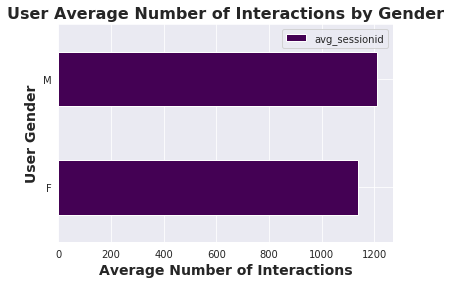

In [34]:
user_avg_iteractions.plot(y='avg_sessionid',x='gender',kind='barh',colormap='viridis')
plt.title("User Average Number of Interactions by Gender",fontsize=16, fontweight='bold');
plt.xlabel("Average Number of Interactions",fontsize=14, fontweight='bold');
plt.ylabel("User Gender",fontsize=14, fontweight='bold');

#### Let's see how many users we have by gender!

In [35]:
level_gender = df_clean.groupby(['gender','level']).agg(F.expr('count(distinct userId)'))

In [36]:
level_gender.show()

+------+-----+-------------+
|gender|level|count(userId)|
+------+-----+-------------+
|     M| free|          212|
|     F| free|          158|
|     F| paid|          150|
|     M| paid|          171|
+------+-----+-------------+



In [37]:
level_gender = level_gender.toPandas()
level_gender = level_gender.pivot(index='gender', columns='level', values='count(userId)')

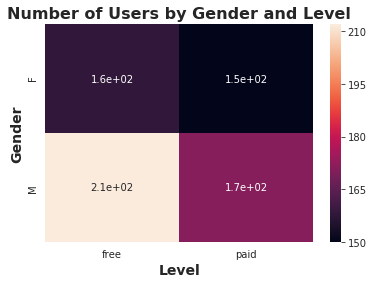

In [38]:
ax = sns.heatmap(level_gender, annot=True)
plt.title("Number of Users by Gender and Level", fontsize=16, fontweight='bold')
plt.xlabel("Level", fontsize=14, fontweight='bold')
plt.ylabel("Gender", fontsize=14, fontweight='bold')
plt.show()

#### Now let's see the different pages we have in Sparkify

In [32]:
print("Unique Pages in the Log Data \n")

df_clean.select("page").dropDuplicates().show()

Unique Pages in the Log Data 

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



#### Let's checkout the most popular artists!

In [33]:
most_played_artists = df_clean.filter(df_clean.page == 'NextSong') \
                              .select('Artist') \
                              .groupBy('Artist') \
                              .agg({'Artist':'count'}) \
                              .withColumnRenamed('count(Artist)', 'Artistcount') \
                              .sort(F.desc('Artistcount'))

In [34]:
most_played_artists.show()

+--------------------+-----------+
|              Artist|Artistcount|
+--------------------+-----------+
|       Kings Of Leon|       3497|
|            Coldplay|       3439|
|Florence + The Ma...|       2314|
|                Muse|       2194|
|       Dwight Yoakam|       2187|
|      The Black Keys|       2160|
|            BjÃÂ¶rk|       2150|
|       Justin Bieber|       2096|
|        Jack Johnson|       2049|
|           Radiohead|       1694|
|              Eminem|       1686|
|     Alliance Ethnik|       1654|
|         OneRepublic|       1651|
|        Taylor Swift|       1555|
|         The Killers|       1554|
|               Train|       1537|
|         Linkin Park|       1487|
|         Evanescence|       1426|
|          John Mayer|       1350|
|            Harmonia|       1344|
+--------------------+-----------+
only showing top 20 rows



In [35]:
most_played_artists = most_played_artists.toPandas()

In [36]:
top_10_artists = most_played_artists.head(10)

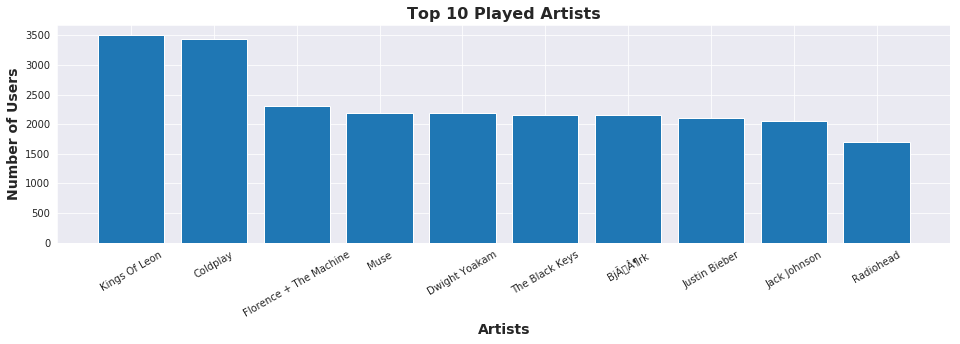

In [40]:
plt.figure(figsize=(16,4))
plt.bar(top_10_artists['Artist'],top_10_artists['Artistcount'])
plt.title("Top 10 Played Artists",fontsize=16, fontweight='bold')
plt.ylabel("Number of Users",fontsize=14, fontweight='bold')
plt.xlabel("Artists",fontsize=14, fontweight='bold')
plt.xticks(rotation=30);

#### Let's Check the Number of Songs users listen to on average between visiting the HomePage

In [42]:
function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(F.desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = df_clean.filter((df_clean.page == 'NextSong') | (df_clean.page == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', function(col('page'))) \
    .withColumn('period', F.sum('homevisit').over(user_window))

cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).show()

+------------------+
|avg(count(period))|
+------------------+
| 23.66741388737015|
+------------------+



### Finally, let's define Churn

In [43]:
churn_fcn = udf(lambda x: 1 if x=='Cancellation Confirmation' else 0)

In [44]:
churned_users = df_clean.withColumn("churn", churn_fcn(col("page")))\
                        .groupby('userId')\
                        .agg(F.max('churn').alias('churned_user'))

In [45]:
churned_users.show(5)

+------+------------+
|userId|churned_user|
+------+------------+
|100010|           1|
|200002|           1|
|   296|           1|
|   125|           0|
|   124|           1|
+------+------------+
only showing top 5 rows



In [58]:
churn_by_gender = df_clean.join(churned_users, ['userId'])\
                          .groupby('gender','churned_user')\
                          .agg(F.expr('count(distinct userId)'))

In [59]:
churn_by_gender.show()

+------+------------+-------------+
|gender|churned_user|count(userId)|
+------+------------+-------------+
|     M|           1|           54|
|     F|           1|           45|
|     F|           0|          153|
|     M|           0|          196|
+------+------------+-------------+



In [60]:
churn_by_gender = churn_by_gender.toPandas()

In [ ]:
churn_by_gender = churn_by_gender.pivot(index='gender', columns='churned_user', values='count(userId)')

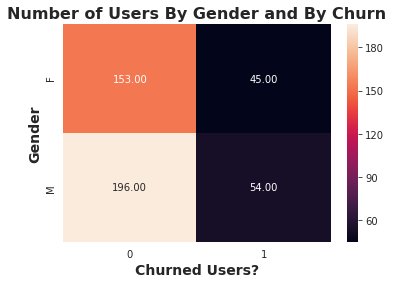

In [63]:
ax = sns.heatmap(churn_by_gender, annot=True,fmt=".2f")
plt.title("Number of Users By Gender and By Churn", fontsize=16, fontweight='bold')
plt.xlabel("Churned Users?", fontsize=14, fontweight='bold')
plt.ylabel("Gender", fontsize=14, fontweight='bold')
plt.show()

## <a class="anchor" id="data-transf">Data Transformation and Feature Engineering</a>

#### In this section I will be performing feature engineering and data transformations in order to create a modeling dataframe that is able to predict Churn.

**1) Number of Songs Each User Listen to on Average Between Visiting the HomePage**

In [67]:
function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(F.desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = df_clean.filter((df_clean.page == 'NextSong') | (df_clean.page == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', function(col('page'))) \
    .withColumn('period', F.sum('homevisit').over(user_window))


num_songs_per_period = cusum.filter((cusum.page == 'NextSong')) \
                      .groupBy('userID', 'period') \
                      .agg({'period':'count'})

avg_songs_btw_hp_per_user = num_songs_per_period.groupby('userID').agg(F.avg('count(period)').alias('avg_songs_btw_hp_per_user'))

In [69]:
avg_songs_btw_hp_per_user.show(5)

+------+-------------------------+
|userID|avg_songs_btw_hp_per_user|
+------+-------------------------+
|100010|                     24.0|
|200002|       14.090909090909092|
|   296|       18.666666666666668|
|   125|                     31.0|
|   124|       27.666666666666668|
+------+-------------------------+
only showing top 5 rows



In [173]:
avg_songs_btw_hp_per_user.describe().show()

+-------+------------------+-------------------------+
|summary|            userID|avg_songs_btw_hp_per_user|
+-------+------------------+-------------------------+
|  count|               448|                      448|
|   mean| 67520.34821428571|       21.687423516103685|
| stddev|105964.58428485187|        6.830830204175801|
|    min|                10|                      1.0|
|    max|                99|                     55.0|
+-------+------------------+-------------------------+



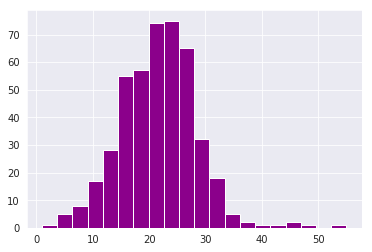

In [78]:
plt.hist(avg_songs_btw_hp_per_user.toPandas()['avg_songs_btw_hp_per_user'],bins=20,color='darkmagenta');

**2) Number of Different Artists Each User Listened To**

In [174]:
num_distinct_artists = df_clean.groupby('UserId').agg(F.countDistinct("artist").alias('num_distinct_artists'))

In [175]:
num_distinct_artists.show(5)

+------+--------------------+
|UserId|num_distinct_artists|
+------+--------------------+
|   296|                 108|
|100010|                  94|
|200002|                 287|
|   125|                  61|
|   124|                1240|
+------+--------------------+
only showing top 5 rows



In [176]:
num_distinct_artists.describe().show()

+-------+------------------+--------------------+
|summary|            UserId|num_distinct_artists|
+-------+------------------+--------------------+
|  count|               448|                 448|
|   mean| 67520.34821428571|   658.9799107142857|
| stddev|105964.58428485182|   625.8826980519568|
|    min|                10|                   1|
|    max|                99|                3507|
+-------+------------------+--------------------+



**3) Number of Songs Listened By Each User**

In [52]:
num_songs_per_user = df_clean.groupby('userId').agg(F.count("song").alias("num_songs_per_user"))

In [172]:
num_songs_per_user.describe().show()

+-------+------------------+------------------+
|summary|            userId|num_songs_per_user|
+-------+------------------+------------------+
|  count|               448|               448|
|   mean| 67520.34821428571| 966.2433035714286|
| stddev|105964.58428485184|1150.8277640292883|
|    min|                10|                 1|
|    max|                99|              8177|
+-------+------------------+------------------+



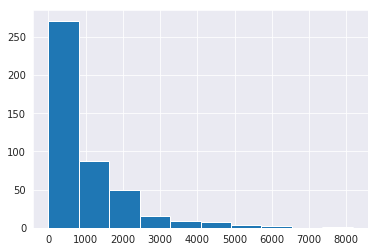

In [57]:
plt.hist(num_songs_per_user.toPandas()['num_songs_per_user']);

**4) How Long Ago a User Signed Up Compared to the Maximum Time Stamp**

In [96]:
max_time_stamp = df_clean.agg(F.max(col("time_stamp")))

In [97]:
max_time_stamp.show()

+-------------------+
|    max(time_stamp)|
+-------------------+
|2018-12-01 00:01:06|
+-------------------+



In [98]:
max_time_stamp = max_time_stamp.collect()[0][0]

In [99]:
max_time_stamp

'2018-12-01 00:01:06'

In [127]:
df_clean.createOrReplaceTempView("user_log_table")

In [139]:
how_long_a_user = spark.sql('''SELECT userId,
                                      datediff('2018-12-01 00:01:06' , registration_date) as how_long_a_user
                               FROM(SELECT userId,
                                           MIN(registration_date) as registration_date
                                    FROM user_log_table
                                    GROUP BY 1)
                            ''')

In [141]:
how_long_a_user.show(5)

+------+---------------+
|userId|how_long_a_user|
+------+---------------+
|100010|             65|
|200002|             86|
|   296|             78|
|   125|            122|
|   124|            132|
+------+---------------+
only showing top 5 rows



In [171]:
how_long_a_user.describe().show()

+-------+------------------+-----------------+
|summary|            userId|  how_long_a_user|
+-------+------------------+-----------------+
|  count|               448|              448|
|   mean| 67520.34821428571|        96.453125|
| stddev|105964.58428485187|37.59155908707851|
|    min|                10|                7|
|    max|                99|              391|
+-------+------------------+-----------------+



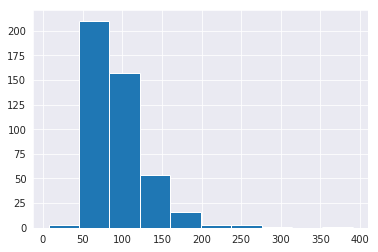

In [143]:
plt.hist(how_long_a_user.toPandas()['how_long_a_user']);

**5) If The User was Ever a Paid User**

In [151]:
free_or_paid = udf(lambda x : 1 if x == 'paid' else 0, IntegerType())
was_paid = udf(lambda x : 1 if x > 0 else 0, IntegerType())

In [155]:
paid_users = df_clean.select('userID', 'level') \
                     .withColumn('free_or_paid', free_or_paid(col('level'))) \
                     .groupby('userID').agg(F.sum('free_or_paid')) \
                     .withColumn('was_paid_user', was_paid(col('sum(free_or_paid)'))).select(['userID','was_paid_user'])

In [169]:
paid_users.show(5)

+------+-------------+
|userID|was_paid_user|
+------+-------------+
|100010|            0|
|200002|            1|
|   296|            1|
|   125|            0|
|    51|            1|
+------+-------------+
only showing top 5 rows



In [170]:
paid_users.describe().show()

+-------+------------------+-------------------+
|summary|            userID|      was_paid_user|
+-------+------------------+-------------------+
|  count|               448|                448|
|   mean| 67520.34821428571| 0.7165178571428571|
| stddev|105964.58428485187|0.45119222592630914|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



**6) The user Gender**

In [166]:
user_gender = spark.sql('''SELECT userId, CASE WHEN gender = 'F' THEN 1 ELSE 0 END as dummy_gender
                           FROM(SELECT distinct userId, gender
                                FROM user_log_table)
                        ''')

In [167]:
user_gender.show(5)

+------+------------+
|userId|dummy_gender|
+------+------------+
|   188|           1|
|   234|           0|
|    44|           1|
|   273|           0|
|    46|           1|
+------+------------+
only showing top 5 rows



In [168]:
user_gender.describe().show()

+-------+------------------+------------------+
|summary|            userId|      dummy_gender|
+-------+------------------+------------------+
|  count|               448|               448|
|   mean| 67520.34821428571|0.4419642857142857|
| stddev|105964.58428485188|0.4971756279079041|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



**7) Overall Time a User Listened to a Song**

In [180]:
user_total_song_length = df_clean.groupby('userID').agg(F.sum(col('length')).alias('user_total_song_length'))

In [181]:
user_total_song_length.show(5)

+------+----------------------+
|userID|user_total_song_length|
+------+----------------------+
|   296|    28314.150059999996|
|100010|    25870.950739999997|
|200002|     78695.82683999998|
|   125|    15813.771070000003|
|    51|     66817.21162999999|
+------+----------------------+
only showing top 5 rows



In [182]:
user_total_song_length.describe().show()

+-------+------------------+----------------------+
|summary|            userID|user_total_song_length|
+-------+------------------+----------------------+
|  count|               448|                   448|
|   mean| 67520.34821428571|    240270.49760906238|
| stddev|105964.58428485184|      286257.952604531|
|    min|                10|             131.00363|
|    max|                99|     2019435.103940004|
+-------+------------------+----------------------+



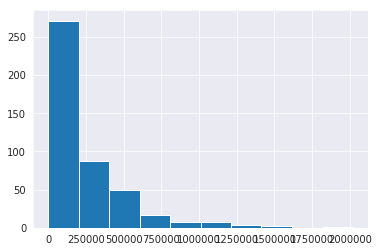

In [184]:
plt.hist(user_total_song_length.toPandas()['user_total_song_length']);

**8) Average Number of Songs Listened Per Session by Each User**

In [201]:
avg_num_songs_per_session = df_clean.filter(df_clean['page']=="NextSong") \
                                    .groupby(['userId','sessionId']).count() \
                                    .groupby('userId').agg(F.avg('count') \
                                    .alias('avg_num_songs_per_session'))

In [202]:
avg_num_songs_per_session.show(5)

+------+-------------------------+
|userId|avg_num_songs_per_session|
+------+-------------------------+
|200002|                     62.0|
|   296|                     22.4|
|100010|                     48.0|
|   125|       20.666666666666668|
|     7|                     30.8|
+------+-------------------------+
only showing top 5 rows



In [203]:
avg_num_songs_per_session.describe().show()

+-------+------------------+-------------------------+
|summary|            userId|avg_num_songs_per_session|
+-------+------------------+-------------------------+
|  count|               448|                      448|
|   mean| 67520.34821428571|         65.6116840997681|
| stddev|105964.58428485185|       39.494965666172675|
|    min|                10|                      1.0|
|    max|                99|                    360.0|
+-------+------------------+-------------------------+



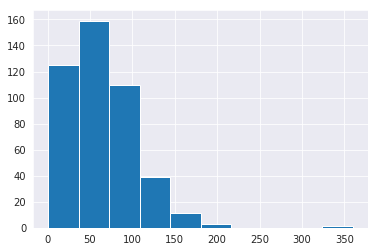

In [206]:
plt.hist(avg_num_songs_per_session.toPandas()['avg_num_songs_per_session']);

**Building Final Dataframe**

In [209]:
modeling_df = avg_songs_btw_hp_per_user.join(num_distinct_artists,'userId')
modeling_df = modeling_df.join(num_songs_per_user,'userId')
modeling_df = modeling_df.join(how_long_a_user,'userId')
modeling_df = modeling_df.join(paid_users,'userId')
modeling_df = modeling_df.join(user_gender,'userId')
modeling_df = modeling_df.join(user_total_song_length,'userId')
modeling_df = modeling_df.join(avg_num_songs_per_session,'userId')
modeling_df = modeling_df.join(churned_users,'userId')

In [210]:
modeling_df.show(5)

+------+-------------------------+--------------------+------------------+---------------+-------------+------------+----------------------+-------------------------+------------+
|userID|avg_songs_btw_hp_per_user|num_distinct_artists|num_songs_per_user|how_long_a_user|was_paid_user|dummy_gender|user_total_song_length|avg_num_songs_per_session|churned_user|
+------+-------------------------+--------------------+------------------+---------------+-------------+------------+----------------------+-------------------------+------------+
|100010|                     24.0|                  94|                96|             65|            0|           1|    25870.950739999997|                     48.0|           1|
|200002|       14.090909090909092|                 287|               310|             86|            1|           0|     78695.82683999998|                     62.0|           1|
|   296|       18.666666666666668|                 108|               112|             78|          

## <a class="anchor" id="etl">ETL Process</a>

#### Now, let's convert the whole data extraction and transformation into a single function that performs this ETL process.

In [211]:
def extract_data():
    """
    Extracts the raw data necessary for modeling Churn.
    
    Output:
        raw_df: a raw dataframe
    """
    raw_df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-cz623hxuazrnhw'))
    
    return raw_df

In [225]:
def transform_data(raw_df):
    """
    Make all the necessary transformations in the raw data and performs
    all the steps of the feature engineering process.
    
    Arguments:
        raw_df: the raw dataframe
    
    Output:
        modeling_df: the transformed dataframe
    """
    
    #Remove NaN Values
    df_clean = raw_df.dropna(how = "any", subset = ["userId", "sessionId"])
    
    #Remove Duplicated Values
    df_clean = df_clean.dropDuplicates()
    
    #Remove Empty Values
    df_clean = df_clean.filter(df_clean.userId != "")
    
    #Adjust Timestamp to Datetime
    get_strftime = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
    df_clean = df_clean.withColumn("time_stamp", get_strftime(col("ts")))
    df_clean = df_clean.withColumn("registration_date", get_strftime(col("registration")))
    
    ###Feature Engineering
    
    ##Target (Churn)
    churn_fcn = udf(lambda x: 1 if x=='Cancellation Confirmation' else 0)
    churned_users = df_clean.withColumn("churn", churn_fcn(col("page")))\
                            .groupby('userId')\
                            .agg(F.max('churn').alias('churned_user'))
    
    ##Features
    #Number of Songs Each User Listen to on Average Between Visiting the HomePage
    function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())
    user_window = Window \
        .partitionBy('userID') \
        .orderBy(F.desc('ts')) \
        .rangeBetween(Window.unboundedPreceding, 0)

    cusum = df_clean.filter((df_clean.page == 'NextSong') | (df_clean.page == 'Home')) \
        .select('userID', 'page', 'ts') \
        .withColumn('homevisit', function(col('page'))) \
        .withColumn('period', F.sum('homevisit').over(user_window))


    num_songs_per_period = cusum.filter((cusum.page == 'NextSong')) \
                          .groupBy('userID', 'period') \
                          .agg({'period':'count'})

    avg_songs_btw_hp_per_user = num_songs_per_period.groupby('userID') \
                                .agg(F.avg('count(period)') \
                                .alias('avg_songs_btw_hp_per_user'))
    
    #Number of Different Artists Each User Listened To
    num_distinct_artists = df_clean.groupby('UserId') \
                           .agg(F.countDistinct("artist") \
                           .alias('num_distinct_artists'))
    
    #Number of Songs Listened By Each User
    num_songs_per_user = df_clean.groupby('userId') \
                         .agg(F.count("song") \
                         .alias("num_songs_per_user"))
    
    #How Long Ago a User Signed Up Compared to the Maximum Time Stamp
    max_time_stamp = df_clean.agg(F.max(col("time_stamp")))
    max_time_stamp = max_time_stamp.collect()[0][0]
    df_clean.createOrReplaceTempView("user_log_table")
    how_long_a_user = spark.sql('''SELECT userId,
                                          datediff('2018-12-01 00:01:06' , registration_date) as how_long_a_user
                                   FROM(SELECT userId,
                                               MIN(registration_date) as registration_date
                                        FROM user_log_table
                                        GROUP BY 1)
                                ''')
    
    #If The User was Ever a Paid User
    free_or_paid = udf(lambda x : 1 if x == 'paid' else 0, IntegerType())
    was_paid = udf(lambda x : 1 if x > 0 else 0, IntegerType())
    paid_users = df_clean.select('userID', 'level') \
                         .withColumn('free_or_paid', free_or_paid(col('level'))) \
                         .groupby('userID').agg(F.sum('free_or_paid')) \
                         .withColumn('was_paid_user', was_paid(col('sum(free_or_paid)'))).select(['userID','was_paid_user'])
    
    #The user Gender
    user_gender = spark.sql('''SELECT userId, CASE WHEN gender = 'F' THEN 1 ELSE 0 END as dummy_gender
                           FROM(SELECT distinct userId, gender
                                FROM user_log_table)
                            ''')
    
    #Overall Time a User Listened to a Song
    user_total_song_length = df_clean.groupby('userID').agg(F.sum(col('length')).alias('user_total_song_length'))
    
    #Average Number of Songs Listened Per Session by Each User
    avg_num_songs_per_session = df_clean.filter(df_clean['page']=="NextSong") \
                                    .groupby(['userId','sessionId']).count() \
                                    .groupby('userId').agg(F.avg('count') \
                                    .alias('avg_num_songs_per_session'))
    
    ##Creating Modeling dataframe
    modeling_df = avg_songs_btw_hp_per_user.join(num_distinct_artists,'userId')
    modeling_df = modeling_df.join(num_songs_per_user,'userId')
    modeling_df = modeling_df.join(how_long_a_user,'userId')
    modeling_df = modeling_df.join(paid_users,'userId')
    modeling_df = modeling_df.join(user_gender,'userId')
    modeling_df = modeling_df.join(user_total_song_length,'userId')
    modeling_df = modeling_df.join(avg_num_songs_per_session,'userId')
    modeling_df = modeling_df.join(churned_users,'userId')
    
    modeling_df = modeling_df.drop('userId')
    
    return modeling_df

In [226]:
def load_data(modeling_df, outpath):
    """
    Save the transformed modeling data into a .csv file.
    
    Arguments:
        modeling_df: the modeling dataframe
        outpath: the output path with the file name
    """
    modeling_df.toPandas().to_csv(outpath)

In [227]:
def perform_etl_process(outpath):
    """
    Performs the full ETL process necessary for predicting
    churn. The final modeling dataframe will be returned and 
    also saved in a .csv file.
    
    Arguments:
        outpath: the output path with the file name
    
    Output:
        modeling_df: the modeling dataframe 
    """
    #Extract
    raw_df = extract_data()
    
    #Transform
    modeling_df = transform_data(raw_df)
    
    #Load
    load_data(modeling_df,'modeling_df.csv')
    
    return modeling_df

In [228]:
modeling_df = perform_etl_process('modeling_df.csv')

#### Let's verify the results of the ETL function!

In [229]:
modeling_df.printSchema()

root
 |-- avg_songs_btw_hp_per_user: double (nullable = true)
 |-- num_distinct_artists: long (nullable = false)
 |-- num_songs_per_user: long (nullable = false)
 |-- how_long_a_user: integer (nullable = true)
 |-- was_paid_user: integer (nullable = true)
 |-- dummy_gender: integer (nullable = false)
 |-- user_total_song_length: double (nullable = true)
 |-- avg_num_songs_per_session: double (nullable = true)
 |-- churned_user: string (nullable = true)



In [230]:
modeling_df.head(5)

[Row(avg_songs_btw_hp_per_user=24.0, num_distinct_artists=94, num_songs_per_user=96, how_long_a_user=65, was_paid_user=0, dummy_gender=1, user_total_song_length=25870.950739999997, avg_num_songs_per_session=48.0, churned_user='1'),
 Row(avg_songs_btw_hp_per_user=14.090909090909092, num_distinct_artists=287, num_songs_per_user=310, how_long_a_user=86, was_paid_user=1, dummy_gender=0, user_total_song_length=78695.82683999997, avg_num_songs_per_session=62.0, churned_user='1'),
 Row(avg_songs_btw_hp_per_user=18.666666666666668, num_distinct_artists=108, num_songs_per_user=112, how_long_a_user=78, was_paid_user=1, dummy_gender=1, user_total_song_length=28314.150059999996, avg_num_songs_per_session=22.4, churned_user='1'),
 Row(avg_songs_btw_hp_per_user=31.0, num_distinct_artists=61, num_songs_per_user=62, how_long_a_user=122, was_paid_user=0, dummy_gender=0, user_total_song_length=15813.771069999997, avg_num_songs_per_session=20.666666666666668, churned_user='0'),
 Row(avg_songs_btw_hp_per_

### <a class="anchor" id="ml">Predicting Churn With Machine Learning</a>

#### Finally, in this section I will be predicting Churn using Machine Learning!

#### Let's first devide the data into training (rest) and validation. Remembering that the rest data will also be splited through a k-fold cross-validation approach.

In [259]:
rest, validation = modeling_df.randomSplit([0.9, 0.1], seed=42)

In [260]:
assembler = VectorAssembler(inputCols=modeling_df.columns[:-1],
                            outputCol="transformeFeatures")
scaler = StandardScaler(inputCol="transformeFeatures",
                        outputCol="features")
indexer = StringIndexer(inputCol="churned_user", outputCol="label")

#### 1) Ligistic Regression

In [261]:
logistic_regressor = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

logistic_regressor_pipeline = Pipeline(stages=[assembler, scaler, indexer, logistic_regressor])

In [262]:
logistic_regressor_paramGrid = ParamGridBuilder() \
                              .addGrid(logistic_regressor.regParam,[0.0, 0.1]) \
                              .build()

logistic_regressor_crossval = CrossValidator(estimator=logistic_regressor_pipeline,
                                             estimatorParamMaps=logistic_regressor_paramGrid,
                                             evaluator=MulticlassClassificationEvaluator(),
                                             numFolds=3)

In [263]:
logistic_regressor_clf = logistic_regressor_crossval.fit(rest)

In [264]:
logistic_regressor_clf.avgMetrics

[0.6944876607196324, 0.6840594290439728]

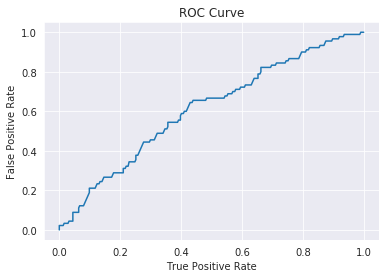

Area Under ROC Curve: 0.6098018400566172


In [283]:
#The ROC plot was extracted from the following post
#(https://towardsdatascience.com/build-an-end-to-end-machine-learning-model-with-mllib-in-pyspark-4917bdf289c5)

#plotting the ROC Curve
trainingSummary = logistic_regressor_clf.bestModel.stages[3].summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Area Under ROC Curve: ' + str(trainingSummary.areaUnderROC))

In [290]:
evaluator = MulticlassClassificationEvaluator()
predictions = logistic_regressor_clf.transform(validation)
print("Accuracy: {}".format(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})))
print("F1 Score:{}".format(evaluator.evaluate(predictions, {evaluator.metricName: "f1"})))

Accuracy: 0.7954545454545454
F1 Score:0.7048331415420023


#### 2) Random Forest Classifier

In [284]:
random_forest = RandomForestClassifier(numTrees=10, 
                                       impurity="gini")

random_forest_pipeline = Pipeline(stages=[assembler, scaler, indexer, random_forest])

In [285]:
random_forest_paramGrid = ParamGridBuilder() \
                          .addGrid(random_forest.maxDepth,[5, 20]) \
                          .build()

random_forest_crossval = CrossValidator(estimator=random_forest_pipeline,
                                        estimatorParamMaps=random_forest_paramGrid,
                                        evaluator=MulticlassClassificationEvaluator(),
                                        numFolds=3)

In [286]:
random_forest_clf = random_forest_crossval.fit(rest)

In [287]:
random_forest_clf.avgMetrics

[0.674946489172487, 0.6808960472755016]

In [291]:
evaluator = MulticlassClassificationEvaluator()
predictions = random_forest_clf.transform(validation)
print("Accuracy: {}".format(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})))
print("F1 Score:{}".format(evaluator.evaluate(predictions, {evaluator.metricName: "f1"})))

Accuracy: 0.75
F1 Score:0.7301369863013697


### Conclusions

#### The first interesting conclusion is that following the directions of a typical CRISP-DM approach allowed an organized and well structered project. I first started the project with some business questions in mind: can we predict churn? What usefull information do I have available that could be usefull in this task? Then, an Explanatory Data Analysis guided the project into usefull insights that was essential for feature engineering.

#### The process of creating features was then guided by a ETL process, where data was first extracted from a json file and then all the necessary transformations were applied. The ETL process was summarized into a function and the resulting modeling database was loaded into a csv file.

#### Machine learning techniques were applied in order to predict churn and satisfactory results were obtained.

#### As a important conclusion, one should notice that more precise results could easily been obtained through a more intense search for parameters in the used models. However, that would require lot more computational power, which also means costs! 

### References
[1] https://www.netigate.net/articles/customer-satisfaction/customer-churn-meaning/

[2] https://stackoverflow.com/questions/21151450/how-can-i-add-a-table-of-contents-to-an-ipython-notebook

[3] https://stackoverflow.com/questions/19746350/how-does-one-change-color-in-markdown-cells-ipython-jupyter-notebook

[4] https://stackoverflow.com/questions/37021964/pyspark-model-interpretation-from-pipeline-model

[5] https://stackoverflow.com/questions/36697304/how-to-extract-model-hyper-parameters-from-spark-ml-in-pyspark

[6] https://stackoverflow.com/questions/44866488/spark-ml-pipeline-with-randomforest-takes-too-long-on-20mb-dataset

[7] https://towardsdatascience.com/build-an-end-to-end-machine-learning-model-with-mllib-in-pyspark-4917bdf289c5

[8] https://stackoverflow.com/questions/51230726/extract-results-from-crossvalidator-with-paramgrid-in-pyspark

[9] https://stackoverflow.com/questions/45024192/pyspark-randomforest-feature-importance-how-to-get-column-names-from-the-column?rq=1

[10] https://stackoverflow.com/questions/40888946/spark-dataframe-count-distinct-values-of-every-column

[11] https://stackoverflow.com/questions/52527571/datediff-in-spark-sql